# Importing packages

In [98]:
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import tensorflow as tf

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler

In [99]:
from utils.model_summary_functions import feature_importance, metrics, summary_plot

In [100]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [104]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [105]:
import warnings # Ignore alert messages
warnings.filterwarnings('ignore')

In [106]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})


In [107]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.integration import KerasPruningCallback

# Importing reduced dataset with engineered features

In [108]:
df = pd.read_csv("Processed_data/FRA3-FRA6_cleaned_feature_engineered.csv.zip") # Dataset from the notebook "feature engineering"
df

,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Z,UA_Z_LR,SuspTravel_L,SuspTravel_R,Pitch_Acc,...,TA_X_RMA,TA_X_MA,TA_X_RMS,TA_Z_mean,SuspTravel_mean,SuspTravel_skew,Pitch_Susp_L_mean,Bounce_Susp_mean,FrontRoll_Susp_skew,Irr_Z_RR
0,-0.034100,0.030900,0.021800,-0.0218,-0.000116,-0.000749,-0.001817,0.030900,-0.034100,-0.000459,...,0.008054,0.000065,0.000457,-0.000293,0.004538,-1.143003,0.000911,0.001606,0.941525,-0.0712
1,-0.035600,0.031600,0.022800,-0.0228,-0.000139,-0.000749,-0.001812,0.031600,-0.035600,-0.000542,...,0.008238,0.000068,0.000457,-0.000307,0.003883,-1.156428,0.000941,0.001485,0.893110,-0.0753
2,-0.036700,0.032000,0.023700,-0.0239,-0.000162,-0.000727,-0.001605,0.032000,-0.036700,-0.000613,...,0.008436,0.000071,0.000458,-0.000320,0.003208,-1.139831,0.000970,0.001362,0.843661,-0.0791
3,-0.037000,0.031400,0.024400,-0.0248,-0.000182,-0.000650,-0.000912,0.031400,-0.037000,-0.000654,...,0.008647,0.000075,0.000459,-0.000332,0.002527,-1.100159,0.000993,0.001242,0.787577,-0.0827
4,-0.037300,0.030900,0.025100,-0.0257,-0.000202,-0.000574,-0.000219,0.030900,-0.037300,-0.000695,...,0.008870,0.000079,0.000459,-0.000342,0.001840,-1.048016,0.001013,0.001125,0.728316,-0.0858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68096,-0.111903,-0.231038,0.133286,0.0503,0.001834,0.000079,0.004336,-0.231038,-0.111903,-0.003638,...,0.053665,0.002880,0.004202,-0.009225,-0.722654,-0.835219,-0.063069,-0.147773,-0.773285,0.0486
68097,-0.113222,-0.225703,0.140285,0.0422,0.001846,-0.000082,0.003567,-0.225703,-0.113222,-0.003363,...,0.053726,0.002887,0.004204,-0.008988,-0.693827,-0.847119,-0.063281,-0.143451,-0.788629,0.0511
68098,-0.114092,-0.220937,0.148758,0.0347,0.001823,-0.000321,0.002644,-0.220937,-0.114092,-0.003317,...,0.053553,0.002868,0.004196,-0.008838,-0.666117,-0.856692,-0.063529,-0.139384,-0.803025,0.0535
68099,-0.114961,-0.216170,0.157232,0.0272,0.001800,-0.000559,0.001721,-0.216170,-0.114961,-0.003272,...,0.053190,0.002829,0.004170,-0.008807,-0.639543,-0.864403,-0.063821,-0.135586,-0.816822,0.0558


In [109]:
def create_scaled_dataset_shuffled(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=0,shuffle=True) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_test.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [110]:
def create_scaled_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    return X_scaled_train, X_scaled_test, y_train, y_test

In [111]:
# y = df['Vert_irreg_right_rail']
# X = df.drop(['Vert_irreg_right_rail'],axis=1)

y = df['Irr_Z_RR']
X = df.drop(['Irr_Z_RR'],axis=1)

X_train1, X_test1, y_train1, y_test1 = create_scaled_dataset_shuffled(X, y)
X_train1

,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Z,UA_Z_LR,SuspTravel_L,SuspTravel_R,Pitch_Acc,...,TA_X_mean,TA_X_RMA,TA_X_MA,TA_X_RMS,TA_Z_mean,SuspTravel_mean,SuspTravel_skew,Pitch_Susp_L_mean,Bounce_Susp_mean,FrontRoll_Susp_skew
52661,-0.482617,0.624161,0.268052,-0.050406,-0.680615,-0.586688,0.419550,0.565724,-0.331250,-0.796251,...,1.237794,0.207241,0.104567,0.003849,-0.188264,0.412402,-0.420101,0.369253,0.910438,0.838786
11859,-2.092162,1.676318,1.409265,-1.016130,-0.985323,0.019258,0.110040,1.404254,-1.612789,0.132473,...,-1.598406,1.657138,1.798189,1.516286,-0.366588,1.484625,-1.313069,1.258865,2.245033,-0.943869
3853,1.057632,-0.527358,0.538417,-0.019297,0.875010,0.946874,0.239970,-0.351994,0.895116,-0.110971,...,-1.018826,-0.233578,-0.325042,-0.505833,0.366055,2.220181,-0.765245,-1.021016,1.757342,0.323758
23748,0.213754,-0.061439,0.250707,-0.268711,-0.170670,0.536590,-0.178934,0.157210,-0.231940,-0.362283,...,-0.540912,-1.043037,-1.010321,-0.973765,0.597864,1.156585,-0.820464,0.106360,0.809949,1.405182
8627,0.477028,-0.120905,1.122329,0.003043,-0.097704,1.895864,-0.167602,0.847796,0.432832,-0.197557,...,-1.078487,-1.015127,-0.988926,-0.533059,-0.022528,2.137029,0.270453,-0.116414,1.201503,-0.827715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41993,1.588313,-1.237718,0.923261,-0.754664,1.035963,-0.154614,-0.253198,-0.918125,1.317651,0.094976,...,-0.550382,-0.024041,-0.125794,-0.126666,0.441502,0.435207,-0.540419,-2.419761,0.337536,-0.782244
21243,-0.204161,0.344191,-1.006928,1.208345,0.746746,0.919383,0.064997,-0.839214,0.941545,0.233786,...,0.998534,0.537280,0.452253,0.130477,0.131942,1.512390,-2.876333,0.097790,1.042273,0.645084
45891,0.392330,-0.362893,-0.159109,0.124463,1.206565,0.585969,-0.172023,-0.220922,0.365394,0.421854,...,0.380354,0.645699,0.571336,0.523125,-0.360311,-0.190244,-0.114305,-0.518469,-0.200309,0.227434
42613,0.369655,0.108723,1.206502,-1.309162,0.394126,0.670117,0.317920,0.914487,-1.058553,-0.368638,...,1.141889,-0.451285,-0.522537,-0.286292,0.104667,-0.823175,-0.807953,-1.367567,-0.549277,1.715345


# Vanilla neural network

In [112]:
class optuna_vanilla_NN:
    
    def __init__(self,X_train,y_train,X_test,y_test):
        self.best_model = None
        self._model = None
    
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        self.callbacks = None
        self.history = None
        self._history = None
        
    def objective(self,trial):
        
        MAX_EPOCHS = 500
        PATIENCE = 12  # Number of epochs to check if the error continues to decrease - early stopping
        INTERVAL = 125  # Intermediate results saved and pruned/removed if it is bad
        
        tf.keras.backend.clear_session()

        # 2. Suggest values of the hyperparameters using a trial object.
        n_layers = 3 #trial.suggest_int('n_layers', 3,4)

        # 3. Create the model
        model = tf.keras.Sequential()
        
        for i in range(n_layers):
            num_neurons = trial.suggest_categorical('n_units_l{}'.format(i), list(np.arange(800,1500,25,dtype=int)))
            activation = trial.suggest_categorical('activ_fun_l{}'.format(i),['linear','relu','tanh']) #linear for 3 layers wasnt good
            model.add(tf.keras.layers.Dense(num_neurons, activation=activation))
            model.add(tf.keras.layers.BatchNormalization())

        model.add(tf.keras.layers.Dense(1, activation='linear'))  # Output layer is linear for regression problems and size 1 because I want a single output
        
        # 4. Defining callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=PATIENCE,
                                                      mode='min')
    
        optuna_pruner = KerasPruningCallback(trial, "val_loss", interval=INTERVAL)
        self.callbacks = [early_stopping,optuna_pruner]
        
        # 5. Compile and fit the model
        learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2) 
        model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=learning_rate))
        
        self._history = model.fit(self.X_train,
              self.y_train,
              epochs=MAX_EPOCHS,
              validation_split=0.15,
              callbacks=self.callbacks,
              shuffle=True,
              verbose=0)   
        
        self._model = model
        
        MSE_score_test_set = model.evaluate(self.X_test, self.y_test, verbose=0)
        return MSE_score_test_set 
    
    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model
            self.history = self._history
            
vanilla_NN = optuna_vanilla_NN(X_train1,y_train1,X_test1,y_test1)

In [113]:
# study = optuna.create_study(direction='minimize',
#                              sampler=optuna.samplers.TPESampler(seed=10), # Fix a seed to have reproducible results
#                              pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
#                              study_name='Vanilla_NN')

In [114]:
# study.optimize(vanilla_NN.objective, 
#                n_trials=100,
#                callbacks=[vanilla_NN.callback],
#                show_progress_bar=True)

[I 2022-11-28 04:06:13,317] Trial 82 finished with value: 0.44605663418769836 and parameters: {'n_units_l0': 1475, 'activ_fun_l0': 'tanh', 'n_units_l1': 1400, 'activ_fun_l1': 'relu', 'n_units_l2': 1475, 'activ_fun_l2': 'relu', 'lr': 0.000996432616496506}. Best is trial 82 with value: 0.44605663418769836.

In [115]:
# i = study.trials_dataframe()
# i

In [116]:
#i['duration'].mean()

In [117]:
#i['duration'].std()

Temporary

In [127]:
class optuna_vanilla_NN_re:
    
    def __init__(self,X_train,y_train,X_test,y_test):
        self.best_model = None
        self._model = None
    
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        self.callbacks = None
        self.history = None
        self._history = None
        
    def objective(self,trial):
        
        MAX_EPOCHS = 500
        PATIENCE = 10  # Number of epochs to check if the error continues to decrease - early stopping
        INTERVAL = 100  # Intermediate results saved and pruned/removed if it is bad
        
        tf.keras.backend.clear_session()

        # 2. Suggest values of the hyperparameters using a trial object.
        n_layers = trial.suggest_int('n_layers', 1,3)

        # 3. Create the model
        model = tf.keras.Sequential()

        for i in range(n_layers):
            num_neurons = trial.suggest_categorical('n_units_l{}'.format(i), list(np.arange(500,1500,10,dtype=int)))
            activation = trial.suggest_categorical('activ_fun_l{}'.format(i),['linear','relu','tanh']) #linear for 3 layers wasnt good
            model.add(tf.keras.layers.Dense(num_neurons, activation=activation))
            #model.add(tf.keras.layers.Dropout(rate=0.3))
            model.add(tf.keras.layers.BatchNormalization())
        
        # act1 = trial.suggest_categorical('activ_fun_l1', ['linear', 'relu', 'tanh'])
        # act2 = trial.suggest_categorical('activ_fun_l2', ['linear', 'relu', 'tanh']) 
        # act3 = trial.suggest_categorical('activ_fun_l3', ['linear', 'relu', 'tanh'])
        
        # num_neurons1 = trial.suggest_categorical('n_units_l1', list(np.arange(500,1500,10,dtype=int)))
        # num_neurons2 = trial.suggest_categorical('n_units_l2', list(np.arange(500,1500,10,dtype=int)))
        # num_neurons3 = trial.suggest_categorical('n_units_l3', list(np.arange(500,1500,10,dtype=int)))
        
        # model.add(tf.keras.layers.Dense(num_neurons1, activation=act1))
        # model.add(tf.keras.layers.BatchNormalization())
        # model.add(tf.keras.layers.BatchNormalization())
        # model.add(tf.keras.layers.Dense(num_neurons2, activation=act2))
        # model.add(tf.keras.layers.BatchNormalization())
        # model.add(tf.keras.layers.Dense(num_neurons3, activation=act3))
        # model.add(tf.keras.layers.BatchNormalization())
        # model.add(tf.keras.layers.Dense(1, activation='linear'))  # Output layer is linear for regression problems and size 1 because I want a single output
        
        # 4. Defining callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=PATIENCE,
                                                      mode='min')
    
        optuna_pruner = KerasPruningCallback(trial, "val_loss", interval=INTERVAL)
        self.callbacks = [early_stopping,optuna_pruner]
        
        # 5. Compile and fit the model
        # trial.suggest_loguniform("lr", 1e-4, 1e-2) # 1e-3
        learning_rate = 1e-3
        model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=learning_rate))
        
        self._history = model.fit(self.X_train,
              self.y_train,
              epochs=MAX_EPOCHS,
              validation_split=0.15,
              callbacks=self.callbacks,
              shuffle=True,
              verbose=0)   
        
        self._model = model
        
        MSE_score_test_set = model.evaluate(self.X_test, self.y_test, verbose=0)
        return MSE_score_test_set 
    
    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model
            self.history = self._history
            
vanilla_NN_re = optuna_vanilla_NN_re(X_train1,y_train1,X_test1,y_test1)

In [128]:
study_re = optuna.create_study(direction='minimize',
                             sampler=optuna.samplers.TPESampler(seed=10), # Fix a seed to have reproducible results
                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                             study_name='Vanilla_NN_re')

[I 2022-11-29 13:52:10,501] A new study created in memory with name: Vanilla_NN_re


In [129]:
study_re.optimize(vanilla_NN_re.objective, 
               n_trials=500,
               callbacks=[vanilla_NN_re.callback],
               show_progress_bar=True)

  0%|          | 1/500 [07:01<58:29:10, 421.95s/it]

[I 2022-11-29 13:59:12,525] Trial 0 finished with value: 11.009065628051758 and parameters: {'n_layers': 3, 'n_units_l0': 1050, 'activ_fun_l0': 'linear', 'n_units_l1': 850, 'activ_fun_l1': 'tanh', 'n_units_l2': 910, 'activ_fun_l2': 'tanh'}. Best is trial 0 with value: 11.009065628051758.


  0%|          | 2/500 [08:38<31:52:29, 230.42s/it]

[I 2022-11-29 14:00:48,877] Trial 1 finished with value: 15.409815788269043 and parameters: {'n_layers': 1, 'n_units_l0': 660, 'activ_fun_l0': 'tanh'}. Best is trial 0 with value: 11.009065628051758.


  1%|          | 3/500 [19:03<56:41:56, 410.70s/it]

[I 2022-11-29 14:11:14,101] Trial 2 finished with value: 14.455309867858887 and parameters: {'n_layers': 2, 'n_units_l0': 700, 'activ_fun_l0': 'tanh', 'n_units_l1': 830, 'activ_fun_l1': 'relu'}. Best is trial 0 with value: 11.009065628051758.


  1%|          | 4/500 [27:34<62:02:53, 450.35s/it]

[I 2022-11-29 14:19:45,239] Trial 3 finished with value: 9.837961196899414 and parameters: {'n_layers': 2, 'n_units_l0': 1310, 'activ_fun_l0': 'tanh', 'n_units_l1': 1240, 'activ_fun_l1': 'tanh'}. Best is trial 3 with value: 9.837961196899414.


  1%|          | 5/500 [37:31<69:10:05, 503.04s/it]

[I 2022-11-29 14:29:41,709] Trial 4 finished with value: 6.950390338897705 and parameters: {'n_layers': 3, 'n_units_l0': 930, 'activ_fun_l0': 'relu', 'n_units_l1': 1280, 'activ_fun_l1': 'tanh', 'n_units_l2': 810, 'activ_fun_l2': 'tanh'}. Best is trial 4 with value: 6.950390338897705.


  1%|          | 6/500 [39:13<50:20:15, 366.83s/it]

[I 2022-11-29 14:31:24,139] Trial 5 finished with value: 15.78998851776123 and parameters: {'n_layers': 2, 'n_units_l0': 1490, 'activ_fun_l0': 'linear', 'n_units_l1': 1040, 'activ_fun_l1': 'linear'}. Best is trial 4 with value: 6.950390338897705.


  1%|▏         | 7/500 [42:02<41:22:56, 302.18s/it]

[I 2022-11-29 14:34:13,223] Trial 6 finished with value: 17.59032440185547 and parameters: {'n_layers': 2, 'n_units_l0': 1150, 'activ_fun_l0': 'relu', 'n_units_l1': 1260, 'activ_fun_l1': 'relu'}. Best is trial 4 with value: 6.950390338897705.


  2%|▏         | 8/500 [43:54<33:00:31, 241.53s/it]

[I 2022-11-29 14:36:04,875] Trial 7 finished with value: 19.450687408447266 and parameters: {'n_layers': 1, 'n_units_l0': 1120, 'activ_fun_l0': 'relu'}. Best is trial 4 with value: 6.950390338897705.


  2%|▏         | 9/500 [45:07<25:44:48, 188.78s/it]

[I 2022-11-29 14:37:17,657] Trial 8 finished with value: 14.879194259643555 and parameters: {'n_layers': 1, 'n_units_l0': 620, 'activ_fun_l0': 'linear'}. Best is trial 4 with value: 6.950390338897705.


  2%|▏         | 10/500 [47:08<22:51:46, 167.97s/it]

[I 2022-11-29 14:39:19,045] Trial 9 finished with value: 17.253868103027344 and parameters: {'n_layers': 2, 'n_units_l0': 1390, 'activ_fun_l0': 'relu', 'n_units_l1': 840, 'activ_fun_l1': 'relu'}. Best is trial 4 with value: 6.950390338897705.


  2%|▏         | 11/500 [52:07<28:15:51, 208.08s/it]

[I 2022-11-29 14:44:18,066] Trial 10 finished with value: 8.605414390563965 and parameters: {'n_layers': 3, 'n_units_l0': 820, 'activ_fun_l0': 'relu', 'n_units_l1': 1280, 'activ_fun_l1': 'tanh', 'n_units_l2': 1170, 'activ_fun_l2': 'tanh'}. Best is trial 4 with value: 6.950390338897705.


  2%|▏         | 12/500 [1:01:59<44:02:37, 324.91s/it]

[I 2022-11-29 14:54:10,198] Trial 11 finished with value: 7.379167079925537 and parameters: {'n_layers': 3, 'n_units_l0': 930, 'activ_fun_l0': 'relu', 'n_units_l1': 1110, 'activ_fun_l1': 'tanh', 'n_units_l2': 810, 'activ_fun_l2': 'tanh'}. Best is trial 4 with value: 6.950390338897705.


  3%|▎         | 13/500 [1:09:25<48:54:31, 361.54s/it]

[I 2022-11-29 15:01:36,030] Trial 12 finished with value: 7.957007884979248 and parameters: {'n_layers': 3, 'n_units_l0': 1170, 'activ_fun_l0': 'relu', 'n_units_l1': 770, 'activ_fun_l1': 'tanh', 'n_units_l2': 810, 'activ_fun_l2': 'tanh'}. Best is trial 4 with value: 6.950390338897705.


Temporary

In [ ]:
study=study_re

In [ ]:
# best_model = vanilla_NN.best_model
# best_model_history = vanilla_NN.history

best_model = vanilla_NN_re.best_model
best_model_history = vanilla_NN_re.history

In [ ]:
best_model.save('models/NN/Vanilla_NN_re')

INFO:tensorflow:Assets written to: models/NN/Vanilla_NN_re\assets


In [ ]:
vanilla_reconstructed_model = tf.keras.models.load_model("models/NN/Vanilla_NN_re")

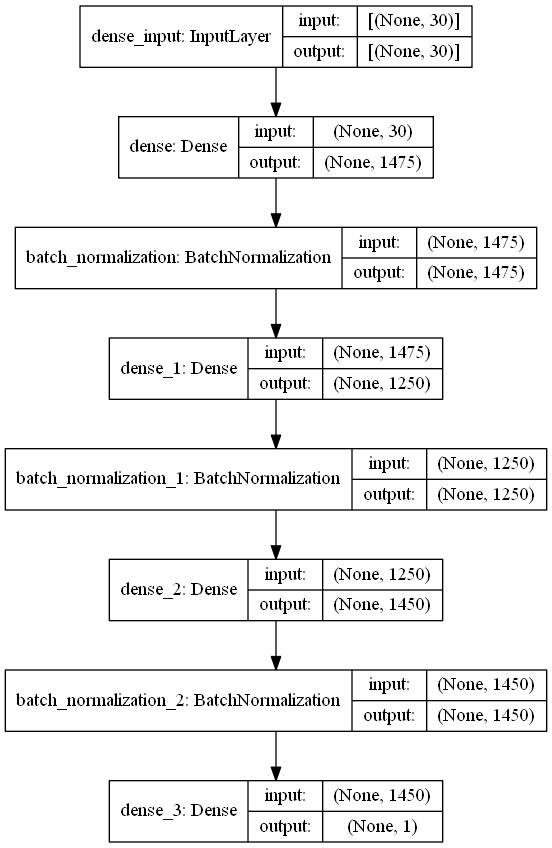

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(vanilla_reconstructed_model, to_file='Images/Vanilla_NNre_plot.png',show_shapes=True, show_layer_names=True)

In [ ]:
vanilla_reconstructed_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1475)              45725     
_________________________________________________________________
batch_normalization (BatchNo (None, 1475)              5900      
_________________________________________________________________
dense_1 (Dense)              (None, 1250)              1845000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1250)              5000      
_________________________________________________________________
dense_2 (Dense)              (None, 1450)              1813950   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1450)              5800      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

## Visualize statistics

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print('')
print('Best value')
print(study.best_value)
print('Best parameters')
print(study.best_params)

Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1

Best value
0.4360769987106323
Best parameters
{}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study) # best plot

ValueError: 
The 'cols' argument to make_suplots must be an int greater than 0.
    Received value of type <class 'int'>: 0

## Model performance

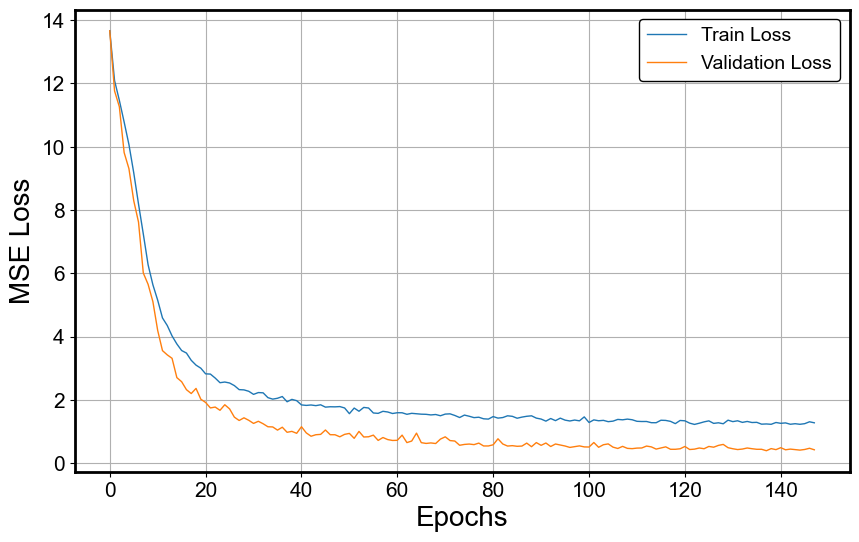

In [ ]:
def plot_learning_curve(model):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,6))
        
    ax.plot(model.history['loss'], label = 'Train Loss')
    ax.plot(model.history['val_loss'], label = 'Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE Loss')
    ax.legend()
    plt.show()
    
plot_learning_curve(best_model_history)

In [ ]:
vanilla_reconstructed_model.evaluate(X_test1,y_test1)

639/639 [==============================] - 2s 2ms/step - loss: 0.4361


0.4360769987106323

In [ ]:
yhat2 = vanilla_reconstructed_model.predict(X_test1)
metrics(yhat2,y_test1)

MSE:0.43607681398151915 
MAE:0.4649102032734531 
R2:0.9864702986556979


In [ ]:
y_test_ordered = pd.DataFrame(y_test1.sort_index(ascending=True))
y_test_ordered=y_test_ordered.to_numpy()
y_test_ordered

array([[-0.0712],
       [-0.0827],
       [-0.0906],
       ...,
       [ 0.0535],
       [ 0.0558],
       [ 0.0578]])

In [ ]:
X_test_ordered = X_test1.sort_index(ascending=True)
yhat = vanilla_reconstructed_model.predict(X_test_ordered)
yhat

array([[ 0.28875107],
       [ 0.24344301],
       [ 0.19965038],
       ...,
       [-0.20011619],
       [-0.20707253],
       [-0.2143029 ]], dtype=float32)

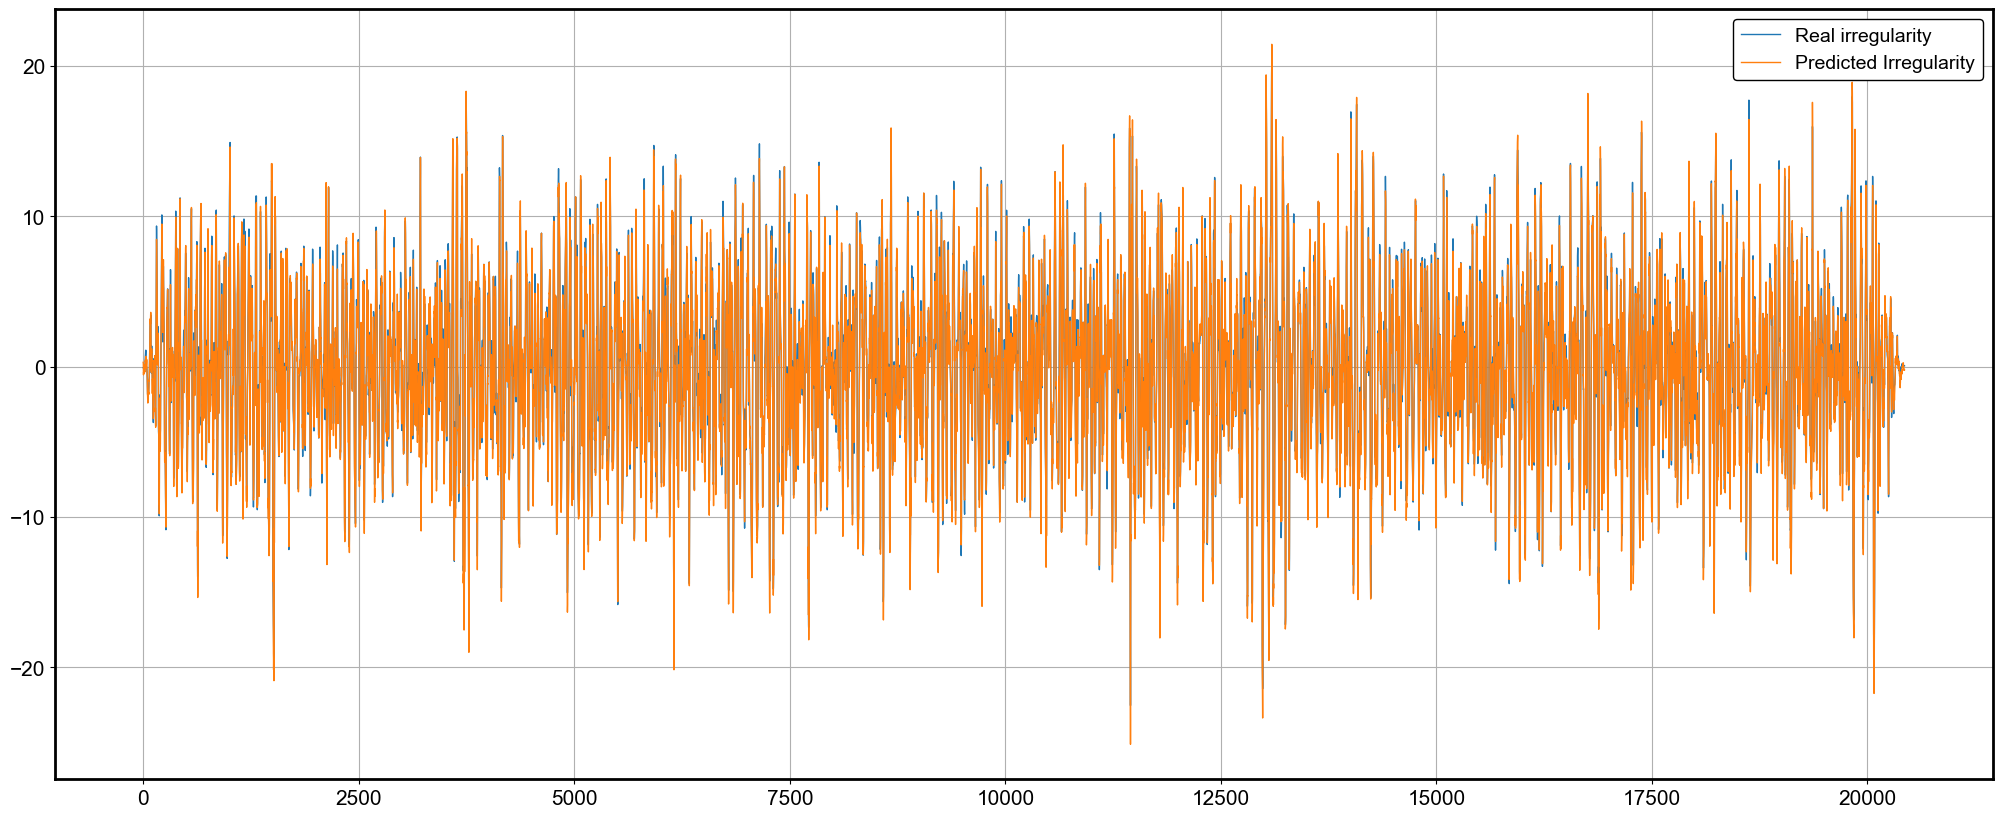

In [ ]:
plt.plot(y_test_ordered,label='Real irregularity')
plt.plot(yhat, label='Predicted Irregularity')
plt.legend()

Text(0.5, 0, 'Distance (m)')

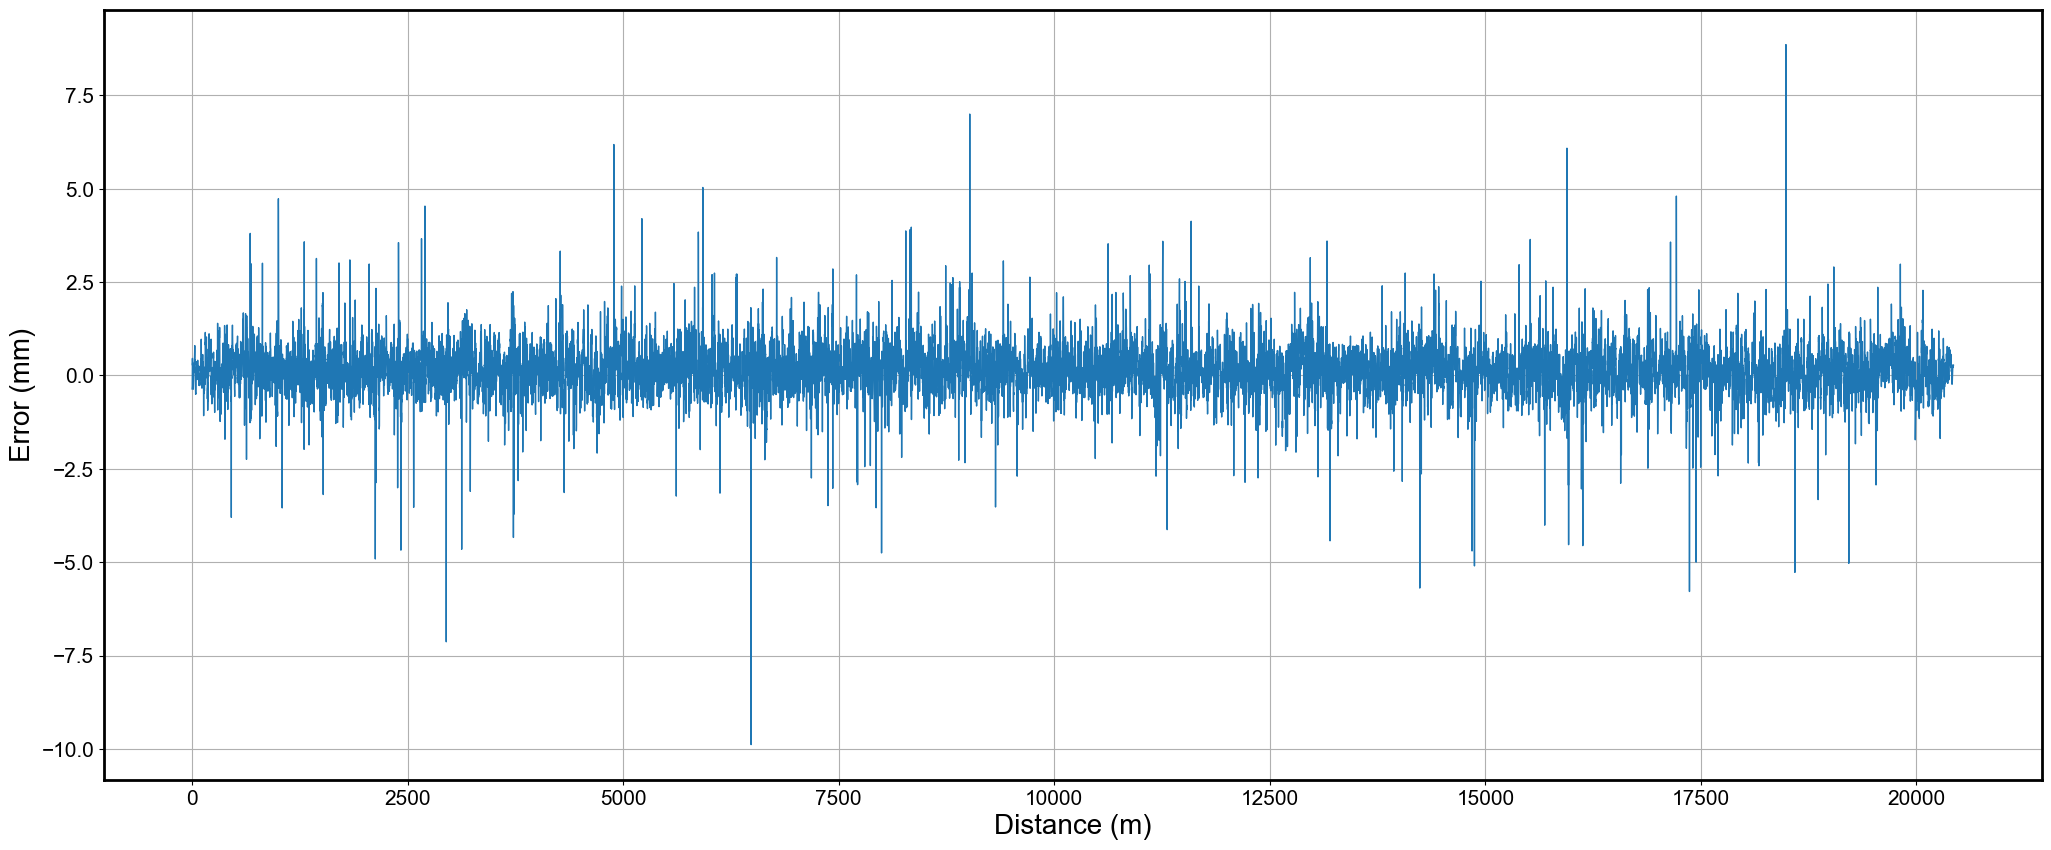

In [ ]:
error = y_test_ordered - yhat
#error = yblau.to_numpy().reshape(-1, 1)- yhat
plt.plot(error)
plt.ylabel('Error (mm)')
plt.xlabel('Distance (m)')

(-20.0, 20.0)

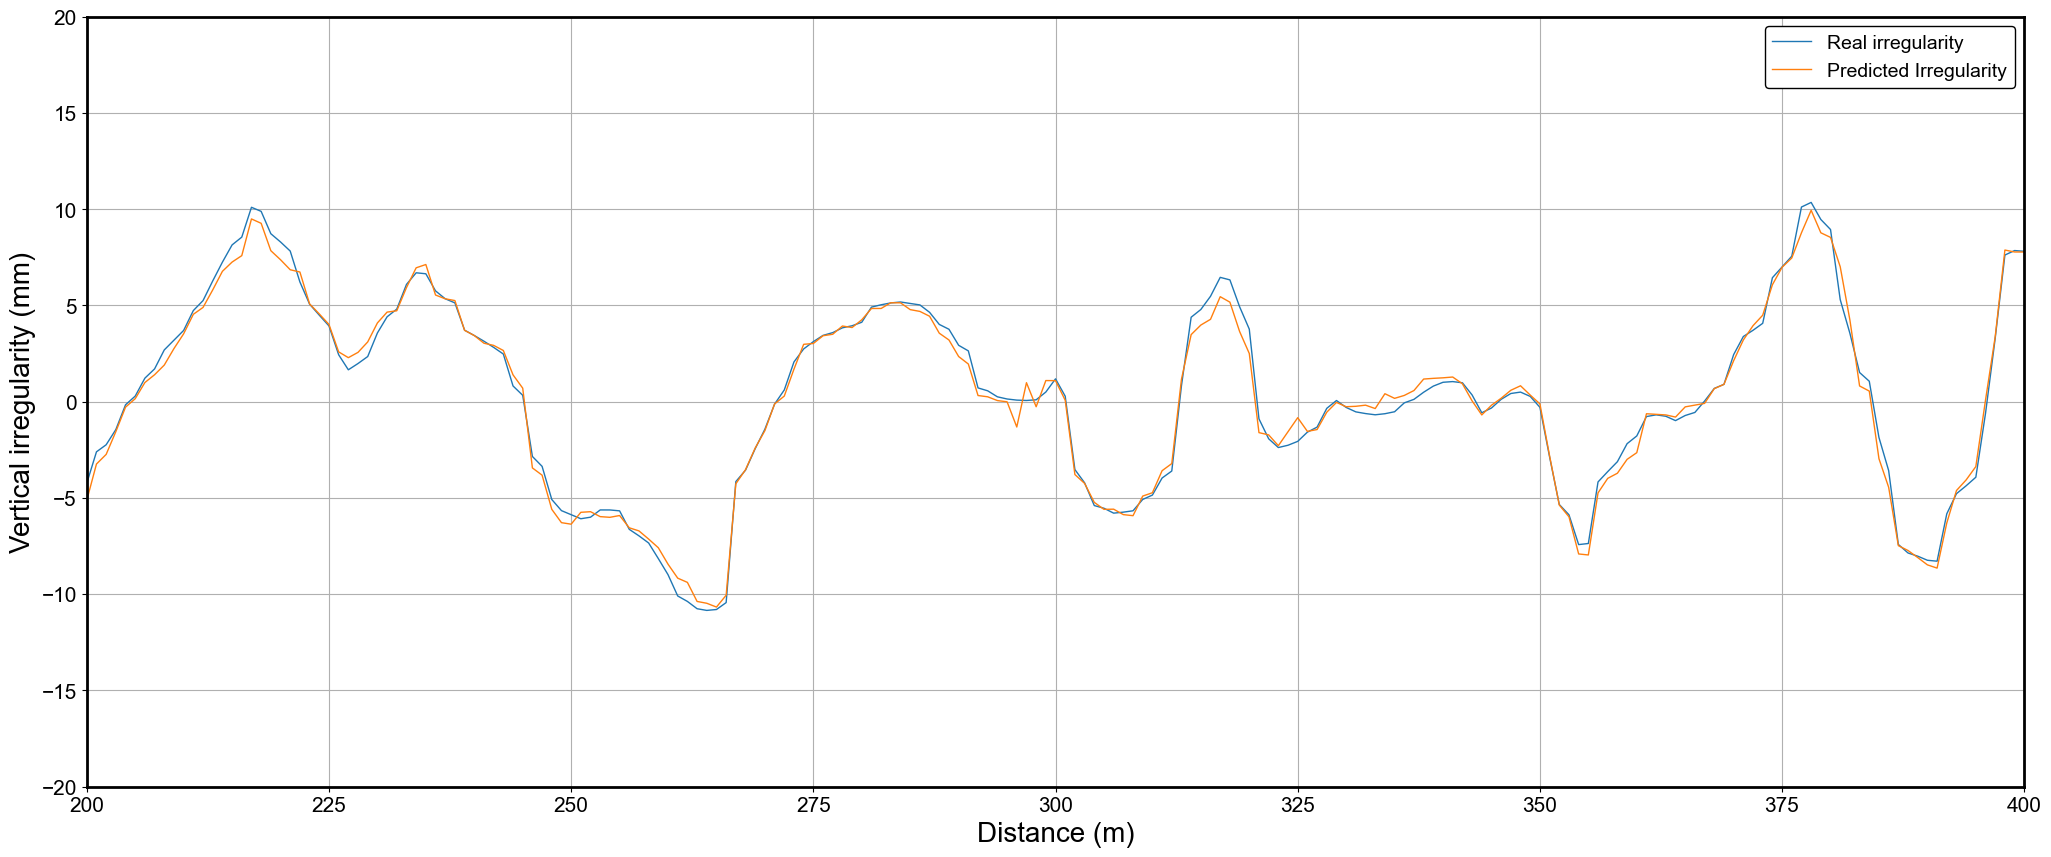

In [ ]:
plt.plot(y_test_ordered,label='Real irregularity')
plt.plot(yhat,label='Predicted Irregularity')
plt.legend()
plt.ylabel('Vertical irregularity (mm)')
plt.xlabel('Distance (m)')

plt.xlim([200,400])
plt.ylim([-20,20])

Text(0.5, 0, 'Distance (m)')

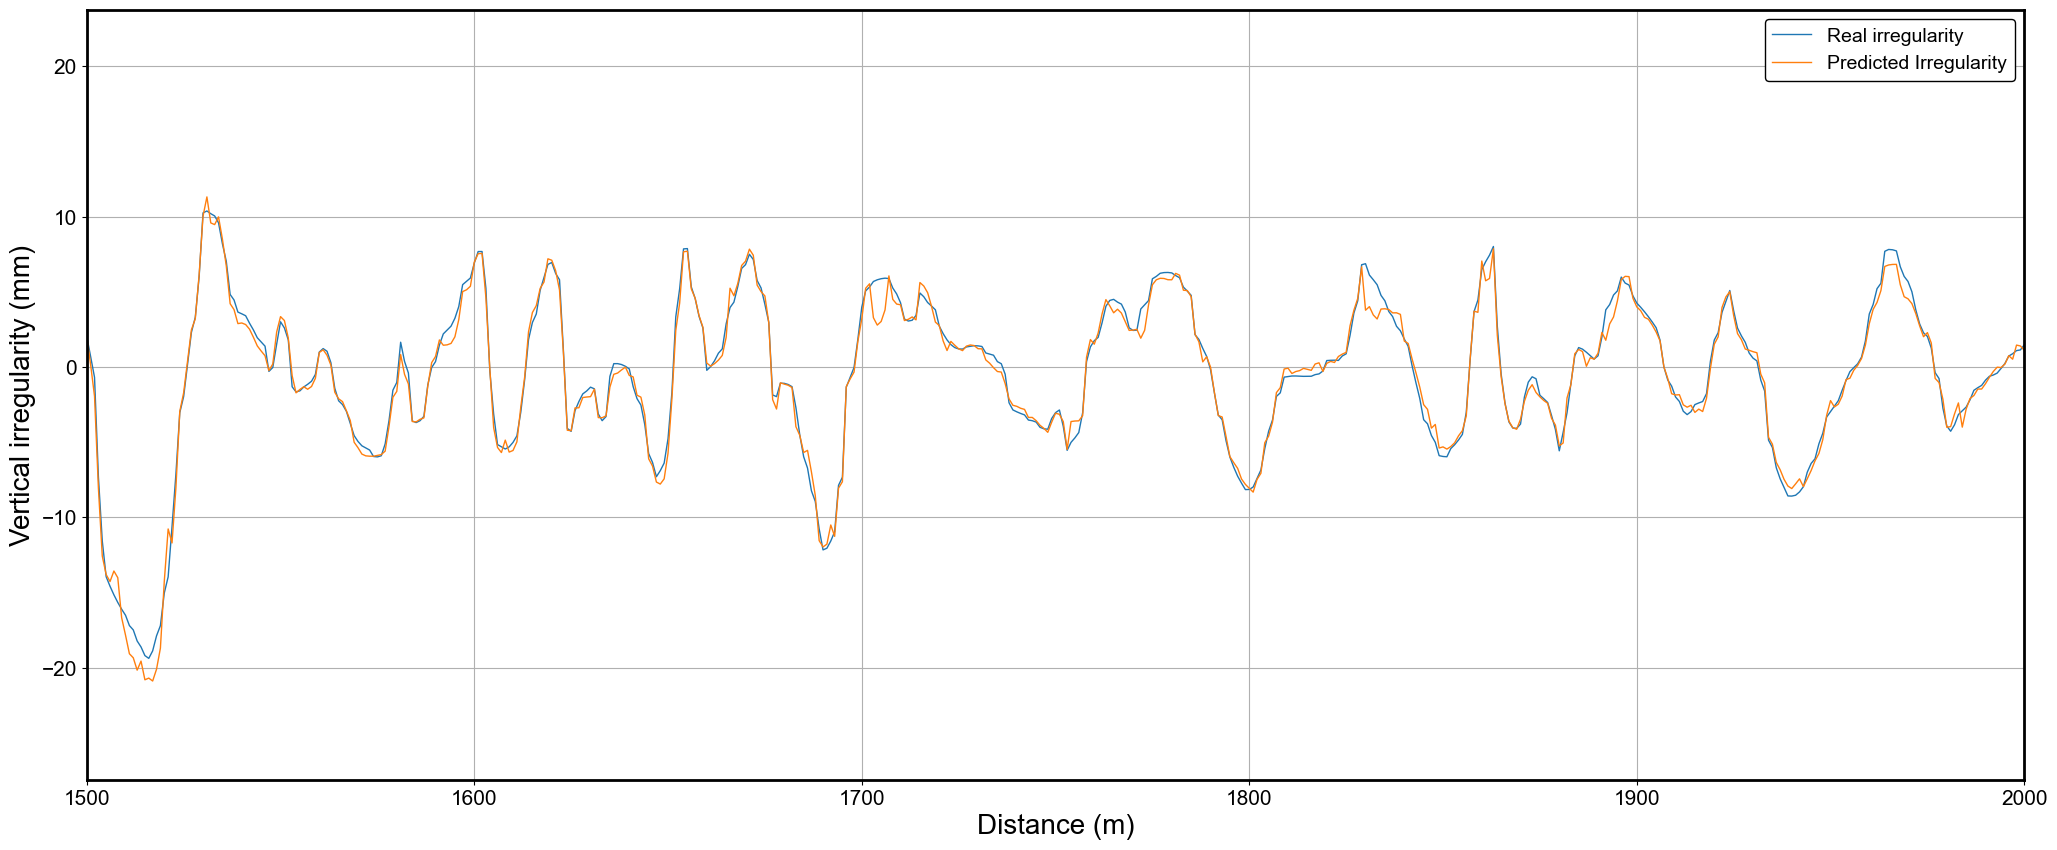

In [ ]:
plt.plot(y_test_ordered, label='Real irregularity')
plt.plot(yhat, label='Predicted Irregularity')
plt.legend()
plt.xlim([1500, 2000])
plt.ylabel('Vertical irregularity (mm)')
plt.xlabel('Distance (m)')

# Visualizing Neural networks with Yellowbricks

Only works for vanilla neural networks

Source: https://github.com/ResidentMario/yellowbrick-x-keras/blob/master/notebooks/using-yellowbrick-with-keras-regressors.ipynb

In [ ]:
from yellowbrick.regressor import ResidualsPlot
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.base import BaseEstimator, RegressorMixin


class KerasReg(BaseEstimator, RegressorMixin, KerasRegressor):

    def __init__(self, build_fn, **kwargs):
        super(KerasRegressor, self).__init__(build_fn,  **kwargs)


def keras_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(650, activation='linear'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(700, activation='linear'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(500, activation='tanh'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1150, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1, activation='linear'))

    learning_rate = 1e-4
    model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=learning_rate))

    return model

In [ ]:
# NN = KerasReg(keras_model, epochs=300, batch_size=2048, verbose=0)
# NN

In [ ]:
# from yellowbrick.regressor import ResidualsPlot

# fig, ax = plt.subplots(figsize=(16, 8))

# visualizer = ResidualsPlot(NN, ax=ax)
# visualizer.fit(X_train1, y_train1)
# visualizer.score(X_test1, y_test1)
# ax.set_ylim([-10,10])

# visualizer.poof()

In [ ]:
# cv = KFold(n_splits=5, shuffle=True, random_state=0)
# summary_plot(NN, X_train1, y_train1, X_test1, y_test1,cv=cv, train_sizes=np.linspace(0.1, 1, 8))